# Linear regression

In [1]:
import numpy as np
from numpy.random import default_rng

import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
rng = default_rng(8675309)

In [3]:
# number of observations
n = 100

In [4]:
# x is Nx1
x = rng.uniform(high=10, size=(n,1))

In [5]:
# random noise e ~ N(0,5^2)
e = rng.normal(0,3,size=(n,1))

In [6]:
# generate y
y = 3 - 2*x + e

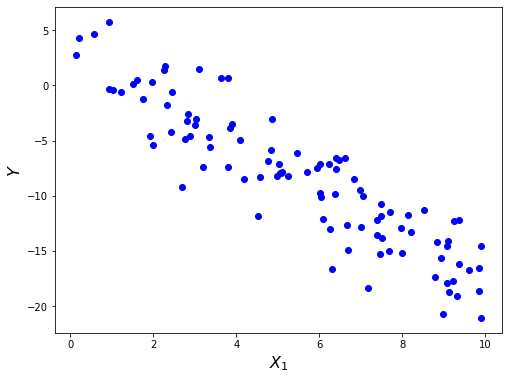

In [7]:
plt.figure(figsize=(8,6))
plt.plot(x, y, 'bo')
plt.xlabel('$X_1$', fontsize=16)
plt.ylabel('$Y$', fontsize=16)
plt.show()

Suppose we think we can describe this data with this function

$$y_i = \beta_0 + \beta_1 x_i + \varepsilon_i $$

or, in vector notation,

$$Y = X\beta + \varepsilon,$$

where $\beta = [\beta_0, \beta_1]'$ and $X$ is a $(K+1)\times N$ matrix with a column of 1s in the first column.

In [8]:
#  construct the X matrix
X = np.c_[np.ones(n), x]

# could also do:
# X = np.column_stack((np.ones(n), x))

In [9]:
X[:5]

array([[1.        , 3.78932572],
       [1.        , 8.14510763],
       [1.        , 6.25815208],
       [1.        , 9.06732906],
       [1.        , 1.51201567]])

Given a particular estimate of $\beta$, which we denote $\hat{\beta}$, we *predict* values for $Y$ using

$$\hat{Y} = X\hat{\beta}.$$

Let's start with a random choice for $\hat{\beta}$ and see what sort of predictions it makes.

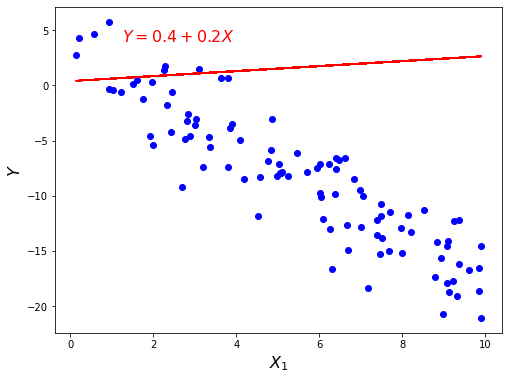

In [10]:
beta_hat = rng.standard_normal((2,1))

y_hat = X @ beta_hat

plt.figure(figsize=(8,6))
plt.plot(x, y, 'bo')
plt.plot(x, y_hat, '-r')
plt.xlabel('$X_1$', fontsize=16)
plt.ylabel('$Y$', fontsize=16)
b0, b1 = beta_hat.reshape(2,)
eqnstr = '$Y={:.1f} {} {:.1f}X$'.format(b0, '+' if b1>0 else '-', abs(b1))
plt.text(1.25, 4, eqnstr, fontsize=16, color='r')
plt.show()

We want to choose parameters that are in some sense "good". One way to do this is choose parameters that make the *prediction error* as small as possible.

$$\hat{\varepsilon} = y - \hat{y}$$

In [11]:
e_hat = y - y_hat
e_hat[:10]

array([[ -8.60419122],
       [-13.98768468],
       [-14.78587484],
       [-20.34902832],
       [ -0.58141829],
       [ -6.77191421],
       [ -8.35717147],
       [ -8.67696493],
       [ -8.54200186],
       [-11.44909418]])

The Mean Squared Error is the average squared error, $$MSE = \frac{1}{n} \sum_i \varepsilon_i^2 = \frac{1}{n} \sum_i (y_i-\hat{y}_i)^2.$$

In vector notation, this is just $$\frac{\varepsilon'\varepsilon}{n} = \frac{(y-X\beta)'(y-X\beta)}{n}.$$

In [12]:
(e_hat**2).sum() / n

147.81525858271073

In [13]:
e_hat.T @ e_hat / n

array([[147.81525858]])

In [14]:
(e_hat.T @ e_hat / n).item()

147.81525858271073

As we choose different values of $\hat{\beta}$ we'll get different values for MSE.

In [15]:
def MSE(b0,b1):
    beta_hat = np.array([b0,b1]).reshape(2,1)
    e_hat = y - X @ beta_hat
    return (e_hat.T @ e_hat).item() / n

In [16]:
MSE(0.6, 1.2)

331.4225081251827

In [17]:
MSE(0.75, 0)

123.29968883046615

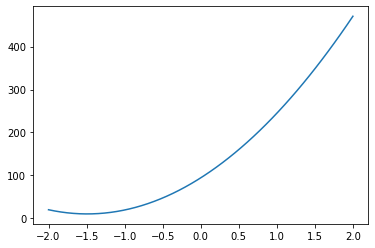

In [18]:
b0 = -1
b1 = np.linspace(-2,2,50)
plt.plot(b1, [(MSE(b0,k)) for k in b1])
plt.show()

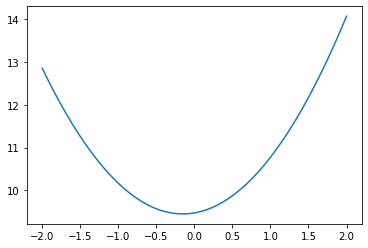

In [19]:
b0 = np.linspace(-2,2,50)
b1 = -1.5
plt.plot(b0, [(MSE(k,b1)) for k in b0])
plt.show()

Let's vary both $\beta_0$ and $\beta_1$ simultaneously.

In [20]:
#  calculate MSE on a "grid" of b0,b1 pairs
b0 = b1 = np.linspace(-5,5,250)

b0, b1 = np.meshgrid(b0,b1)

MSE_v = np.vectorize(MSE)

Z = MSE_v(b0, b1)

In [21]:
# what values generate the minimum?
minidx = np.unravel_index(Z.argmin(), Z.shape)

b0[minidx], b1[minidx]

(3.19277108433735, -2.108433734939759)

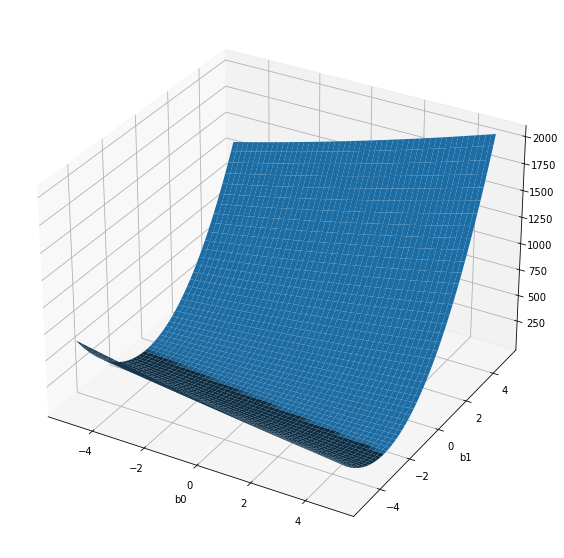

In [22]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')

ax.plot_surface(b0, b1, Z)
ax.set_xlabel('b0')
ax.set_ylabel('b1')

plt.show()

Note, however, that this is really not a good way to find these parameters. We had to check blindly if possible parameter values worked well. What if we didn't start looking in the right spot? (What if $\beta_0=-523$ and $\beta_1=4367$?)

## Gradient descent

We can do much better by using the derivatives of the MSE to tell us where to look for better parameter values.

With two parameter values, the MSE function is

$$MSE = \frac{1}{N} \sum_{i=1}^N \left[y_i - (\beta_0 + \beta_1 x_i)\right]^2.$$

The partial derivatives are therefore $$\frac{\partial MSE}{\partial \beta_0} = -\frac{2}{N} \sum_i \left[y_i - (\beta_0 + \beta_1 x_i)\right]$$ and $$\frac{\partial MSE}{\partial \beta_1} = -\frac{2}{N} \sum_i x_i \left[y_i - (\beta_0 + \beta_1 x_i)\right].$$

In vector notation, this is
$$\frac{\partial}{\partial \beta} \frac{(y-X\beta)'(y-X\beta)}{N} = -\frac{2}{N} X'(y-X\beta) = \frac{2}{N} X'(X\beta-y).$$

In [23]:
def do_plot():
    fig = plt.figure(figsize=(12,9))
    ax = plt.axes(xlim=(-0.2, 10.2), ylim=(-25,10))    
    plt.plot(x, y, 'bo')
    plt.plot(x, y_hat, '-r')
    b0, b1 = 𝛽.reshape(2,)
    txt_str = ('$\\beta$ = [{:.2f}, {:.2f}]\n'.format(b0,b1) 
               + '$\\frac{\\partial MSE}{\\partial \\beta}$=' 
               + '[{:.4f}, {:.4f}]\n'.format(*gradient.ravel())
               + 'MSE: {:.4f}'.format(MSE(b0,b1)))  
    plt.text(0, -20, txt_str, fontsize=14)

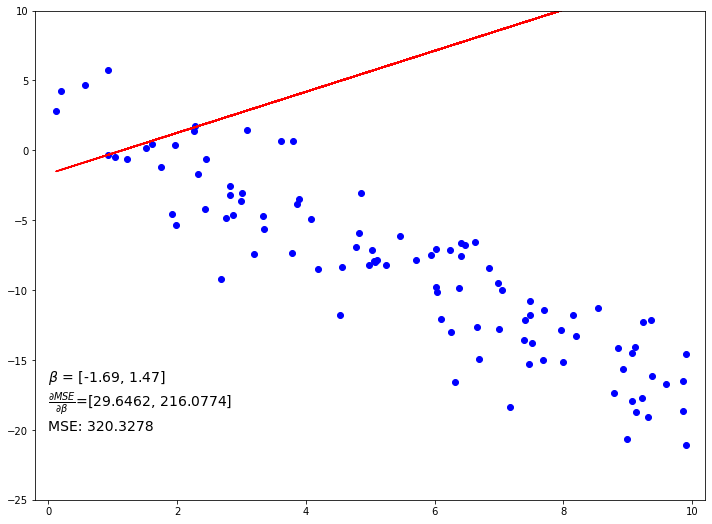

In [28]:
𝛽 = rng.standard_normal((2,1))  # random initialization

y_hat = X @ 𝛽

gradient = -2/n * X.T @ (y - X@𝛽)

do_plot()

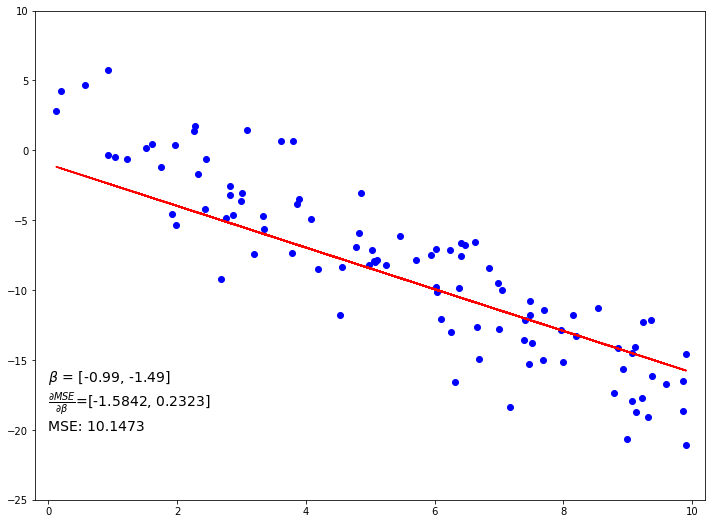

In [59]:
𝜂 = 0.02  # learning rate

# calculates gradients and update 𝛽
gradient = -2/n * X.T @ (y - X@𝛽)
𝛽 = 𝛽 - 𝜂*gradient

y_hat = X @ 𝛽

do_plot()

What happens when we make the learning rate 𝜂 bigger? Experiment and see!

In [ ]:
#  ONLY FOR ME

from matplotlib import animation

fig = plt.figure(figsize=(12,9))
ax = plt.axes(xlim=(0, 10), ylim=(-25,10))
ax.plot(x,y,'bo')
line, = ax.plot([], [], '-r')
txt = ax.text(7.75, 3.5, '', fontsize=16, color='k')

# initial guess
𝛽 = np.array([0,0]).reshape(2,1)

def animate(i):
    global 𝛽, gradient
    if i>0: 𝛽 = 𝛽 - 𝜂*gradient
    gradient = -2/N * X.T @ (y - X@𝛽)
    y_hat = X @ 𝛽
    line.set_data(x, y_hat)
    b0, b1 = 𝛽.reshape(2,)
    txt_str = (f'Iteration: {i}\n' + '$\\beta$ = [{:.2f}, {:.2f}]\n'.format(b0,b1) 
               + '$\\frac{\\partial MSE}{\\partial \\beta}$=' 
               + '[{:.2f}, {:.2f}]\n'.format(*gradient.ravel())
               + 'MSE: {:.4f}'.format(MSE(b0,b1)))
    txt.set_text(txt_str)
    return line,

anim = animation.FuncAnimation(fig, animate, frames=251, blit=True)

anim.save('regression.mp4', fps=5, extra_args=['-vcodec', 'libx264'])

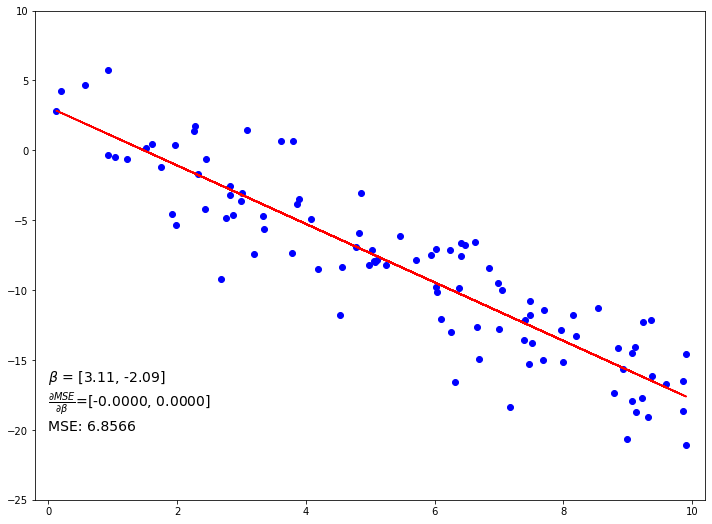

In [62]:
n_iterations = 1500

𝛽 = rng.standard_normal((2,1))  # random initialization

for iteration in range(n_iterations):
    gradient = -2/n * X.T @ (y - X@𝛽)
    𝛽 = 𝛽 - 𝜂*gradient
    
y_hat = X @ 𝛽

do_plot()

At this point the gradient is very small, indicating that the next guess for $\beta$ would be quite close to what it is in this iteration. In other words, the algorithm has *converged*.

In [27]:
gradient

array([[-1.43832435e-05],
       [ 2.10912660e-06]])

This iterative technique is used by off-the-shelf optimizers, like the one in scipy.

In [63]:
from scipy.optimize import minimize

In [64]:
# redefine MSE so it takes a single array argument
def MSE(beta_hat):
    beta_hat = np.array(beta_hat).reshape(2,1)
    e_hat = y - X @ beta_hat
    return (e_hat.T @ e_hat).item() / n

In [65]:
minimize(MSE, x0=[0,0])

      fun: 6.856609907378583
 hess_inv: array([[ 2.53282568, -0.36917307],
       [-0.36917307,  0.06703782]])
      jac: array([ 1.07288361e-06, -7.27176666e-06])
  message: 'Optimization terminated successfully.'
     nfev: 21
      nit: 6
     njev: 7
   status: 0
  success: True
        x: array([ 3.10717488, -2.09131257])

## Analytical solution

We can also try to find an analytical solution to the problem of minimizing MSE. Setting the gradient equal to zero, we have:

$$\frac{2}{N} X'(X\beta-y) = 0$$

This implies the *normal equation* $X'X\hat{\beta} = X'y,$ which must hold for the function to be minimized.

As long as $X'X$ is invertible, the solution to the normal equation is 
$$\hat{\beta} = (X'X)^{-1}X'y.$$

$X'X$ is invertible when $K<N$, but even if it is theoretically invertible it may be computationally quite difficult if $K$ is large.

In [66]:
XpX = X.T @ X

In [67]:
XpX

array([[ 100.        ,  551.1599446 ],
       [ 551.1599446 , 3777.82863606]])

Notice that $X'X$ contains values of $N$, $\sum x$ and $\sum x^2$ and has dimension $k\times k$.

In [70]:
X[:,0].sum()

100.0

In [71]:
X[:,1].sum()

551.159944597104

In [72]:
(X[:,1]**2).sum()

3777.828636059256

In the simple $k=2$ case with $\beta = (\beta_0, \beta_1)$, this simplifies to

\begin{align}
(X'X)^{-1}X'y &= \begin{pmatrix}
n & \sum x\\ 
\sum x & \sum x^2
\end{pmatrix}^{-1}
\begin{pmatrix}
\sum y\\ 
\sum xy
\end{pmatrix}\\
&= \frac{1}{n\sum(x-\bar{x})^2}
\begin{pmatrix}
\sum x^2 & -\sum x\\ 
-\sum x & n
\end{pmatrix}
\begin{pmatrix}
\sum y\\ 
\sum xy
\end{pmatrix},
\end{align}

which we can show gives exactly the same solutions as we found using MLE:

$$\hat{\beta}_0 = \bar{y} - \hat{\beta}_1 \bar{x},$$

$$\hat{\beta}_1 = \frac{\sum(y_i-\bar{y})(x_i-\bar{x})}{\sum (x_i-\bar{x})^2}.$$

We can calculate the coefficients by simply writing the equation for $\hat{\beta}$. Not surprisingly, these are exactly what the iterative algorithm found.

In [74]:
from numpy.linalg import inv

In [75]:
beta = inv(X.T @ X) @ X.T @ y

beta

array([[ 3.10716922],
       [-2.09131164]])

In [76]:
y_hat = X @ beta

In [77]:
e_hat = y - y_hat

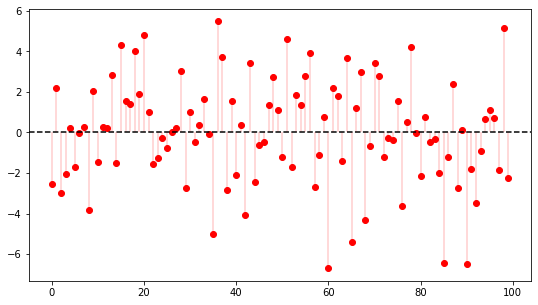

In [79]:
plt.figure(figsize=(9,5))
plt.scatter(np.arange(n), e_hat, color='r')
plt.vlines(np.arange(n), 0, e_hat, lw=0.3, color='r')
plt.axhline(0, ls='--', c='k')
plt.show()

## Sum of squares

The Total Sum of Squares in the data is $\sum_i (y_i-\bar{y})^2 = (y-\bar{y})'(y-\bar{y}).$

In [80]:
TSS = ((y-y.mean())**2).sum()
TSS

3922.3574246168273

In [81]:
(y-y.mean()).T @ (y-y.mean())

array([[3922.35742462]])

We use the Total Sum of Squares and the Residual Sum of Squares to calculate $R^2$, a measure of how much of the variation in the data our model can explain.

$R^2 \equiv \frac{TSS - RSS}{TSS} = 1- \frac{RSS}{TSS}$

In [82]:
RSS = e_hat.T @ e_hat

In [83]:
1 - RSS/TSS

array([[0.82519161]])

## statsmodels

In [84]:
import statsmodels.api as sm

In [87]:
model = sm.OLS(y, X)
results = model.fit()

In [88]:
results.params

array([ 3.10716922, -2.09131164])

In [89]:
y_pred = results.predict()

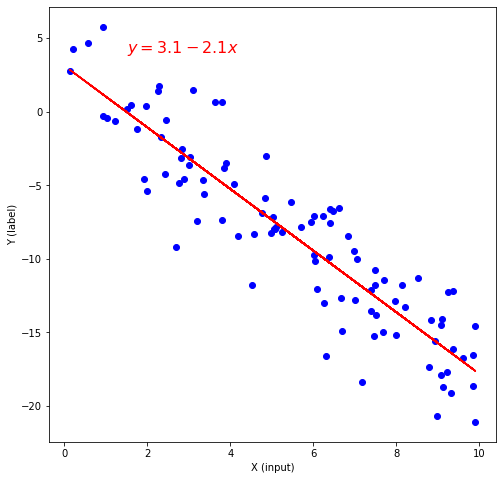

In [90]:
plt.figure(figsize=(8,8))
plt.plot(x, y, 'bo')
plt.xlabel("X (input)")
plt.ylabel("Y (label)")
plt.plot(x, y_pred, 'r')

b0, b1 = results.params

eqnstr = '$y={:.1f} {} {:.1f}x$'.format(b0, '+' if b1>0 else '-', abs(b1))
plt.text(1.5, 4, eqnstr, fontsize=16, color='r')
plt.show()

In [91]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.825
Model:                            OLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                     462.6
Date:                Tue, 23 Feb 2021   Prob (F-statistic):           6.79e-39
Time:                        10:22:07   Log-Likelihood:                -238.15
No. Observations:                 100   AIC:                             480.3
Df Residuals:                      98   BIC:                             485.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.1072      0.598      5.199      0.0

## sklearn

In [92]:
from sklearn.linear_model import LinearRegression

In [93]:
lin_reg = LinearRegression()
lin_reg.fit(x, y)  # note that we don't pass the X matrix augmented with 1s

LinearRegression()

In [94]:
lin_reg.intercept_

array([3.10716922])

In [95]:
lin_reg.coef_

array([[-2.09131164]])

In [96]:
lin_reg.score(x,y)

0.8251916088947017

## Nonlinear data

What if our data isn't linear?

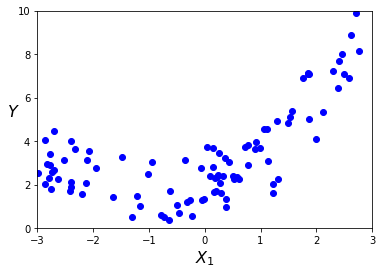

In [69]:
x = 6 * rng.uniform(size=(n,1)) - 3
y = 2 + x + 0.5*x**2 + rng.standard_normal(size=(n, 1))

plt.plot(x, y, "bo")
plt.xlabel("$X_1$", fontsize=16)
plt.ylabel("$Y$", rotation=0, fontsize=16)
plt.axis([-3, 3, 0, 10])
plt.show()

In [70]:
X = np.c_[np.ones(n), x, x**2]

In [71]:
model2 = sm.OLS(y, X)
results2 = model2.fit()

In [72]:
print(results2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.816
Model:                            OLS   Adj. R-squared:                  0.812
Method:                 Least Squares   F-statistic:                     214.5
Date:                Wed, 17 Feb 2021   Prob (F-statistic):           2.48e-36
Time:                        16:10:36   Log-Likelihood:                -142.40
No. Observations:                 100   AIC:                             290.8
Df Residuals:                      97   BIC:                             298.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.8945      0.146     13.008      0.0

In [73]:
from sklearn.preprocessing import PolynomialFeatures

In [74]:
poly_features = PolynomialFeatures(degree=2)
x_poly = poly_features.fit_transform(x)

In [75]:
x_poly[0]

array([ 1.        , -2.13152943,  4.54341773])

In [76]:
X[0]

array([ 1.        , -2.13152943,  4.54341773])

In [77]:
lin_reg2 = LinearRegression(fit_intercept=False)
lin_reg2.fit(x_poly, y)
lin_reg2.coef_

array([[1.89452528, 1.08224875, 0.53571285]])

In [78]:
poly_features = PolynomialFeatures(degree=4)
x_poly = poly_features.fit_transform(x)

lin_reg2.fit(x_poly, y)
lin_reg2.coef_

array([[ 1.87933657,  0.95941528,  0.58001767,  0.0208049 , -0.00557499]])

In [79]:
lin_reg2.coef_

array([[ 1.87933657,  0.95941528,  0.58001767,  0.0208049 , -0.00557499]])

sklearn doesn't give standard errors but we can calculate them

$R^2 = 1- \frac{RSS}{TSS}$

In [80]:
RSS = (1 - lin_reg2.score(x_poly, y)) * y.var()*n

The variance-covariance matrix of the coeffient estimates is given by $\sigma^2(X'X)^{-1}.$ We estimate $\sigma^2$ with $$\hat{\sigma}^2 = \frac{RSS}{N-K}.$$

In [81]:
N, K = x_poly.shape
RSS / (N-K) * inv(x_poly.T @ x_poly)

array([[ 2.98055637e-02, -4.22788701e-03, -1.57932618e-02,
         6.84245942e-04,  1.61268210e-03],
       [-4.22788701e-03,  2.90811748e-02,  6.53505735e-04,
        -4.39791028e-03, -8.72208245e-05],
       [-1.57932618e-02,  6.53505735e-04,  1.93843505e-02,
        -2.64806652e-04, -2.41563761e-03],
       [ 6.84245942e-04, -4.39791028e-03, -2.64806652e-04,
         7.69938536e-04,  4.78795003e-05],
       [ 1.61268210e-03, -8.72208245e-05, -2.41563761e-03,
         4.78795003e-05,  3.23211274e-04]])

The diagonal elements of this matrix give the estimated variance of each coefficent, which we can use to calculate the standard errors.

In [82]:
varcov = RSS / (N-K) * inv(x_poly.T @ x_poly)

np.sqrt(varcov.diagonal())

array([0.17264288, 0.17053203, 0.13922769, 0.02774777, 0.01797808])

# t-statistics

In [83]:
lin_reg2.coef_ / np.sqrt(varcov.diagonal())

array([[10.88568829,  5.62601205,  4.16596481,  0.74978644, -0.31009908]])

Now let's estimate the same model with statsmodels.

In [84]:
model3 = sm.OLS(y, x_poly)
results3 = model3.fit()

print(results3.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.817
Model:                            OLS   Adj. R-squared:                  0.809
Method:                 Least Squares   F-statistic:                     106.0
Date:                Wed, 17 Feb 2021   Prob (F-statistic):           3.75e-34
Time:                        16:11:37   Log-Likelihood:                -142.03
No. Observations:                 100   AIC:                             294.1
Df Residuals:                      95   BIC:                             307.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.8793      0.173     10.886      0.0